In [1]:
#Reference => sentdex tutorial on Youtube
!pip install gym #already installed

In [2]:
import gym
env = gym.make('CartPole-v0') #for discription https://github.com/openai/gym/wiki/CartPole-v0
env.reset()

array([ 0.04136745, -0.0475222 , -0.01930477, -0.01227903])

In [3]:
import random
done = False

while not done:
  action = (int(random.random()*10))%2 #action 0->push cart left; action 1->push cart right
  state, reward, done, _ = env.step(action)# state is a tuple of (cart position, cart velocity, pole angle, pole velocity at tip)
  print(state)  
  env.render()

env.close()

#the cart need to balance the pole as much as possible

[ 0.04041701  0.14787121 -0.01955035 -0.31098978]
[ 0.04337443 -0.04696683 -0.02577015 -0.02453602]
[ 0.0424351  -0.24170991 -0.02626087  0.25990604]
[ 0.0376009  -0.43644732 -0.02106275  0.54419163]
[ 0.02887195 -0.24103582 -0.01017891  0.2449474 ]
[ 0.02405124 -0.43601092 -0.00527997  0.53440235]
[ 0.01533102 -0.24081511  0.00540808  0.24006042]
[ 0.01051472 -0.04577084  0.01020929 -0.05091175]
[ 0.0095993  -0.24103768  0.00919105  0.24497473]
[ 0.00477855 -0.0460482   0.01409055 -0.044795  ]
[ 0.00385758  0.1488689   0.01319465 -0.33299914]
[ 0.00683496  0.34380058  0.00653467 -0.6214921 ]
[ 0.01371097  0.14858799 -0.00589518 -0.32675829]
[ 0.01668273 -0.04644954 -0.01243034 -0.03594025]
[ 0.01575374  0.14884844 -0.01314915 -0.33251901]
[ 0.01873071  0.34415506 -0.01979953 -0.62931935]
[ 0.02561381  0.14931493 -0.03238591 -0.34293712]
[ 0.02860011 -0.04533167 -0.03924466 -0.06064012]
[ 0.02769348 -0.2398696  -0.04045746  0.21940713]
[ 0.02289608 -0.43439058 -0.03606932  0.49905859]


## Implementing Q Table

We will be implementing SARSAMAX

![](SARSAMAX.png)

- State contains continous values
- Q Table will contains prohibitively large number of state values
- We need to **dicretize them** in order to create Q Table
- Initially Q Table will contain random values

In [4]:
#display observation space low and high values
print(env.observation_space.high)#[position,cart_velocity,pole_angle,pole_velocity]
print(env.observation_space.low)#[position,cart_velocity,pole_angle,pole_velocity]
print(env.action_space.n)

[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
2


In [5]:
#Reference 1 for discretizizng -> https://medium.com/@tuzzer/cart-pole-balancing-with-q-learning-b54c6068d947 
#Reference 2 for discretizing -> https://github.com/deepakkavoor/cartpole-rl/blob/master/cartpole-q_learning.py
import math
env.observation_space.high[1]= 0.5
env.observation_space.low[1]= -0.5
env.observation_space.high[3]= math.radians(50)
env.observation_space.low[3]= -math.radians(50)

## Now we will implement SARSAMAX algorithm to fill the Q Table

In [35]:
import numpy as np
LEARNING_RATE = 0.05 #hyperparameter 
DISCOUNT = 0.95 #hyperparameter; how important are future rewards  
EPISODES = 50000 #hyperparameter
RENDER_EVERY = 1000
episode_rewards=[]#to store total reward obtained in each step
aggr_ep_rewards = {'ep': [], 'avg': [], 'max': [], 'min': []}#To store various stats


#Reference for discretizing=> https://mc.ai/openai-gyms-cart-pole-balancing-using-q-learning/
buckets=(1, 1, 6, 12,) #hyperparameter -> dimensions of Q Table (position,cart_velocity,pole_angle,pole_velocity)
q_table = np.zeros(buckets + (env.action_space.n,))
print(q_table.shape)



#a helper function to discretize continous states as returned by the environment 
def get_discrete_state(state):
    ratios = [(state[i] + abs(env.observation_space.low[i])) / (env.observation_space.high[i] - env.observation_space.low[i]) for i in range(len(state))]
    new_obs = [int(round((buckets[i] - 1) * ratios[i])) for i in range(len(state))]
    new_obs = [min(buckets[i] - 1, max(0, new_obs[i])) for i in range(len(state))]
    return tuple(new_obs)

(1, 1, 6, 12, 2)


In [36]:
# Exploration settings
epsilon = 1  # not a constant, qoing to be decayed
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = EPISODES//2
epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)

In [37]:
for episode in range(EPISODES):
    done = False
    discrete_state = get_discrete_state(env.reset()) #we always start with initial discrete state'
    if episode % RENDER_EVERY == 0:
        render=True
        print(episode)
    else:
        render=False
    steps_per_episode = 0
    episode_reward = 0#To track each episode rewards
    while not done:
        
        if render:
            env.render()
            steps_per_episode+=1
            print('Step Count'+str(steps_per_episode))
        
        if np.random.random() > epsilon:
            # Get action from Q table
            action = np.argmax(q_table[discrete_state])
        else:
            # Get random action
            action = np.random.randint(0, env.action_space.n)
        
        state, reward, done, _ = env.step(action)# state is a tuple of (position,cart_velocity,pole_angle,pole_velocity)
        episode_reward += reward
        new_discrete_state = get_discrete_state(state)
        if not done:
            q_st_at=q_table[discrete_state+(action,)]
            q_st_plus_1_a = np.max(q_table[new_discrete_state])
            new_q_st_at = q_st_at + LEARNING_RATE * (reward + DISCOUNT * q_st_plus_1_a - q_st_at)
            q_table[discrete_state+(action,)] = new_q_st_at
        discrete_state = new_discrete_state
    
    # Decaying is being done every episode if episode number is within decaying range
    if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
        epsilon -= epsilon_decay_value
    
    episode_rewards.append(episode_reward)
    if not episode % RENDER_EVERY:
        avg_reward = sum(episode_rewards[-RENDER_EVERY:])/RENDER_EVERY
        aggr_ep_rewards['ep'].append(episode)
        aggr_ep_rewards['avg'].append(avg_reward)
        aggr_ep_rewards['max'].append(max(episode_rewards[-RENDER_EVERY:]))
        aggr_ep_rewards['min'].append(min(episode_rewards[-RENDER_EVERY:]))
        
env.close()

0
Step Count1
Step Count2
Step Count3
Step Count4
Step Count5
Step Count6
Step Count7
Step Count8
Step Count9
Step Count10
Step Count11
Step Count12
Step Count13
Step Count14
Step Count15
Step Count16
Step Count17
Step Count18
Step Count19
Step Count20
Step Count21
Step Count22
Step Count23
Step Count24
Step Count25
Step Count26
Step Count27
Step Count28
Step Count29
Step Count30
Step Count31
Step Count32
Step Count33
Step Count34
Step Count35
Step Count36
Step Count37
Step Count38
Step Count39
1000
Step Count1
Step Count2
Step Count3
Step Count4
Step Count5
Step Count6
Step Count7
Step Count8
Step Count9
Step Count10
Step Count11
Step Count12
Step Count13
Step Count14
Step Count15
Step Count16
2000
Step Count1
Step Count2
Step Count3
Step Count4
Step Count5
Step Count6
Step Count7
Step Count8
Step Count9
Step Count10
Step Count11
Step Count12
Step Count13
Step Count14
Step Count15
Step Count16
Step Count17
Step Count18
Step Count19
Step Count20
Step Count21
Step Count22
Step Count23
S

15000
Step Count1
Step Count2
Step Count3
Step Count4
Step Count5
Step Count6
Step Count7
Step Count8
Step Count9
Step Count10
Step Count11
Step Count12
Step Count13
Step Count14
Step Count15
Step Count16
Step Count17
Step Count18
Step Count19
Step Count20
Step Count21
Step Count22
Step Count23
Step Count24
Step Count25
Step Count26
Step Count27
Step Count28
Step Count29
Step Count30
Step Count31
Step Count32
Step Count33
Step Count34
Step Count35
Step Count36
Step Count37
Step Count38
Step Count39
Step Count40
Step Count41
Step Count42
Step Count43
Step Count44
Step Count45
Step Count46
Step Count47
Step Count48
Step Count49
Step Count50
Step Count51
Step Count52
Step Count53
Step Count54
Step Count55
Step Count56
Step Count57
Step Count58
Step Count59
Step Count60
Step Count61
Step Count62
Step Count63
Step Count64
Step Count65
Step Count66
Step Count67
Step Count68
Step Count69
Step Count70
Step Count71
Step Count72
Step Count73
Step Count74
Step Count75
Step Count76
Step Count77
St

Step Count126
Step Count127
Step Count128
Step Count129
Step Count130
Step Count131
Step Count132
Step Count133
Step Count134
Step Count135
Step Count136
Step Count137
Step Count138
Step Count139
Step Count140
Step Count141
Step Count142
Step Count143
Step Count144
Step Count145
Step Count146
Step Count147
Step Count148
Step Count149
Step Count150
Step Count151
Step Count152
Step Count153
Step Count154
Step Count155
Step Count156
Step Count157
Step Count158
Step Count159
Step Count160
Step Count161
Step Count162
Step Count163
Step Count164
Step Count165
Step Count166
Step Count167
Step Count168
Step Count169
Step Count170
Step Count171
Step Count172
Step Count173
Step Count174
Step Count175
Step Count176
Step Count177
Step Count178
Step Count179
Step Count180
Step Count181
Step Count182
Step Count183
Step Count184
Step Count185
Step Count186
Step Count187
Step Count188
Step Count189
Step Count190
Step Count191
Step Count192
Step Count193
Step Count194
Step Count195
Step Count196
Step C

Step Count106
Step Count107
Step Count108
Step Count109
Step Count110
Step Count111
Step Count112
Step Count113
Step Count114
Step Count115
Step Count116
Step Count117
Step Count118
Step Count119
Step Count120
Step Count121
Step Count122
Step Count123
Step Count124
Step Count125
Step Count126
Step Count127
Step Count128
Step Count129
Step Count130
Step Count131
Step Count132
Step Count133
Step Count134
Step Count135
Step Count136
Step Count137
Step Count138
Step Count139
Step Count140
Step Count141
Step Count142
Step Count143
Step Count144
Step Count145
Step Count146
Step Count147
Step Count148
Step Count149
Step Count150
Step Count151
Step Count152
Step Count153
Step Count154
Step Count155
Step Count156
Step Count157
Step Count158
Step Count159
Step Count160
Step Count161
Step Count162
Step Count163
Step Count164
Step Count165
Step Count166
Step Count167
Step Count168
Step Count169
Step Count170
Step Count171
Step Count172
Step Count173
Step Count174
Step Count175
Step Count176
Step C

29000
Step Count1
Step Count2
Step Count3
Step Count4
Step Count5
Step Count6
Step Count7
Step Count8
Step Count9
Step Count10
Step Count11
Step Count12
Step Count13
Step Count14
Step Count15
Step Count16
Step Count17
Step Count18
Step Count19
Step Count20
Step Count21
Step Count22
Step Count23
Step Count24
Step Count25
Step Count26
Step Count27
Step Count28
Step Count29
Step Count30
Step Count31
Step Count32
Step Count33
Step Count34
Step Count35
Step Count36
Step Count37
Step Count38
Step Count39
Step Count40
Step Count41
Step Count42
Step Count43
Step Count44
Step Count45
Step Count46
Step Count47
Step Count48
Step Count49
Step Count50
Step Count51
Step Count52
Step Count53
Step Count54
Step Count55
Step Count56
Step Count57
Step Count58
Step Count59
Step Count60
Step Count61
Step Count62
Step Count63
Step Count64
Step Count65
Step Count66
Step Count67
Step Count68
Step Count69
Step Count70
Step Count71
Step Count72
Step Count73
Step Count74
Step Count75
Step Count76
Step Count77
St

Step Count110
Step Count111
Step Count112
Step Count113
Step Count114
Step Count115
Step Count116
Step Count117
Step Count118
Step Count119
Step Count120
Step Count121
Step Count122
Step Count123
Step Count124
Step Count125
Step Count126
Step Count127
Step Count128
Step Count129
Step Count130
Step Count131
Step Count132
Step Count133
Step Count134
Step Count135
Step Count136
Step Count137
Step Count138
Step Count139
Step Count140
Step Count141
Step Count142
Step Count143
Step Count144
Step Count145
Step Count146
Step Count147
Step Count148
Step Count149
Step Count150
Step Count151
Step Count152
Step Count153
Step Count154
Step Count155
Step Count156
Step Count157
Step Count158
Step Count159
Step Count160
Step Count161
Step Count162
Step Count163
Step Count164
Step Count165
Step Count166
Step Count167
Step Count168
Step Count169
Step Count170
Step Count171
Step Count172
Step Count173
Step Count174
Step Count175
Step Count176
Step Count177
Step Count178
Step Count179
Step Count180
Step C

Step Count144
Step Count145
Step Count146
Step Count147
Step Count148
Step Count149
Step Count150
Step Count151
Step Count152
Step Count153
Step Count154
Step Count155
Step Count156
Step Count157
Step Count158
Step Count159
Step Count160
Step Count161
Step Count162
Step Count163
Step Count164
Step Count165
Step Count166
Step Count167
Step Count168
Step Count169
Step Count170
Step Count171
Step Count172
Step Count173
Step Count174
Step Count175
Step Count176
Step Count177
Step Count178
Step Count179
Step Count180
Step Count181
Step Count182
Step Count183
Step Count184
Step Count185
Step Count186
Step Count187
Step Count188
Step Count189
Step Count190
Step Count191
Step Count192
Step Count193
Step Count194
Step Count195
Step Count196
Step Count197
Step Count198
Step Count199
Step Count200
36000
Step Count1
Step Count2
Step Count3
Step Count4
Step Count5
Step Count6
Step Count7
Step Count8
Step Count9
Step Count10
Step Count11
Step Count12
Step Count13
Step Count14
Step Count15
Step Count

39000
Step Count1
Step Count2
Step Count3
Step Count4
Step Count5
Step Count6
Step Count7
Step Count8
Step Count9
Step Count10
Step Count11
Step Count12
Step Count13
Step Count14
Step Count15
Step Count16
Step Count17
Step Count18
Step Count19
Step Count20
Step Count21
Step Count22
Step Count23
Step Count24
Step Count25
Step Count26
Step Count27
Step Count28
Step Count29
Step Count30
Step Count31
Step Count32
Step Count33
Step Count34
Step Count35
Step Count36
Step Count37
Step Count38
Step Count39
Step Count40
Step Count41
Step Count42
Step Count43
Step Count44
Step Count45
Step Count46
Step Count47
Step Count48
Step Count49
Step Count50
Step Count51
Step Count52
Step Count53
Step Count54
Step Count55
Step Count56
Step Count57
Step Count58
Step Count59
Step Count60
Step Count61
Step Count62
Step Count63
Step Count64
Step Count65
Step Count66
Step Count67
Step Count68
Step Count69
Step Count70
Step Count71
Step Count72
Step Count73
Step Count74
Step Count75
Step Count76
Step Count77
St

Step Count108
Step Count109
Step Count110
Step Count111
Step Count112
Step Count113
Step Count114
Step Count115
Step Count116
Step Count117
Step Count118
Step Count119
Step Count120
Step Count121
Step Count122
Step Count123
Step Count124
Step Count125
Step Count126
Step Count127
Step Count128
Step Count129
Step Count130
Step Count131
Step Count132
Step Count133
Step Count134
Step Count135
Step Count136
Step Count137
Step Count138
Step Count139
Step Count140
Step Count141
Step Count142
Step Count143
Step Count144
Step Count145
Step Count146
Step Count147
Step Count148
Step Count149
Step Count150
Step Count151
Step Count152
Step Count153
Step Count154
Step Count155
Step Count156
Step Count157
Step Count158
Step Count159
Step Count160
Step Count161
Step Count162
Step Count163
Step Count164
Step Count165
Step Count166
Step Count167
Step Count168
Step Count169
Step Count170
Step Count171
Step Count172
Step Count173
Step Count174
Step Count175
Step Count176
Step Count177
Step Count178
Step C

Step Count142
Step Count143
Step Count144
Step Count145
Step Count146
Step Count147
Step Count148
Step Count149
Step Count150
Step Count151
Step Count152
Step Count153
Step Count154
Step Count155
Step Count156
Step Count157
Step Count158
Step Count159
Step Count160
Step Count161
Step Count162
Step Count163
Step Count164
Step Count165
Step Count166
Step Count167
Step Count168
Step Count169
Step Count170
Step Count171
Step Count172
Step Count173
Step Count174
Step Count175
Step Count176
Step Count177
Step Count178
Step Count179
Step Count180
Step Count181
Step Count182
Step Count183
Step Count184
Step Count185
Step Count186
Step Count187
Step Count188
Step Count189
Step Count190
Step Count191
Step Count192
Step Count193
Step Count194
Step Count195
Step Count196
Step Count197
Step Count198
Step Count199
Step Count200
46000
Step Count1
Step Count2
Step Count3
Step Count4
Step Count5
Step Count6
Step Count7
Step Count8
Step Count9
Step Count10
Step Count11
Step Count12
Step Count13
Step Cou

Step Count191
Step Count192
Step Count193
Step Count194
Step Count195
Step Count196
Step Count197
Step Count198
Step Count199
Step Count200
49000
Step Count1
Step Count2
Step Count3
Step Count4
Step Count5
Step Count6
Step Count7
Step Count8
Step Count9
Step Count10
Step Count11
Step Count12
Step Count13
Step Count14
Step Count15
Step Count16
Step Count17
Step Count18
Step Count19
Step Count20
Step Count21
Step Count22
Step Count23
Step Count24
Step Count25
Step Count26
Step Count27
Step Count28
Step Count29
Step Count30
Step Count31
Step Count32
Step Count33
Step Count34
Step Count35
Step Count36
Step Count37
Step Count38
Step Count39
Step Count40
Step Count41
Step Count42
Step Count43
Step Count44
Step Count45
Step Count46
Step Count47
Step Count48
Step Count49
Step Count50
Step Count51
Step Count52
Step Count53
Step Count54
Step Count55
Step Count56
Step Count57
Step Count58
Step Count59
Step Count60
Step Count61
Step Count62
Step Count63
Step Count64
Step Count65
Step Count66
Step 

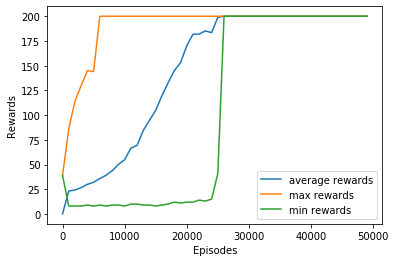

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt 
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label="average rewards")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label="max rewards")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label="min rewards")
plt.legend(loc=4)
plt.show()

In [25]:
print(aggr_ep_rewards['ep'])
print(aggr_ep_rewards['min'])
print(aggr_ep_rewards['avg'])

[0, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 0, 2500, 5000, 7500, 10000, 12500, 15000, 17500]
[200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0]
[0.0072, 27.7816, 50.6412, 110.4584, 177.382, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0]


## Sample Run of Agent

In [10]:

done = False
discrete_state = get_discrete_state(env.reset()) #we always start with initial discrete state'
steps=0
while not done:
    steps+=1
    print(steps)
    env.render()
        
    action = np.argmax(q_table[discrete_state])
        
    state, reward, done, _ = env.step(action)# state is a tuple of (position,cart_velocity,pole_angle,pole_velocity)

    discrete_state=get_discrete_state(state)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
